# Earnings Return Prediction - Template (v1 20250429)

In this project we will train a model to predict the stock return on the day of earnings for US companies. This template contains code to get you started with the project.

## Standard imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

## Notebook configuration
- Please set the **<span style="color:red">config['enddate']</span>** to the most recent Friday. Do not change any other config parameters. 

- The environment might take around one minute to load
- The  **Operators** are functions that can be used to apply a series of transformations to a data variable or alpha.
> [Introduction to Operators](https://trexsim.com/trexsim/pysim/tutorial2022/operators.html)
> 
> Find all available  operators in the [operators list](https://www.trexsim.com/trexsim/pysim/comptutorial/operators.html)

In [1]:
# import operators as op              # find all available operators, https://www.trexsim.com/trexsim/pysim/comptutorial/operators.html
# import utilities as utils
# import strategy_utilities as sutil
# from strategy_research import load_env

# config = {
#     'enddate': 20240712,            # Please setting the config['enddate'] to the most recent Friday.
#     'region': 'USA',
#     'universe': 'top3000',
#     'delay': 0,
#     'booksize':1e6,
#     'refit_interval': 'OneQuarter',
#     'filter_function_uuid': 'none',
#     'fit_function_uuid': 'none',
#     'pp_function_uuid': 'none',
#     'tf_function_uuid': 'none',
#     'postalpha': False,
#     'compress': False,    
#     'load_cache': False,
#     'save_cache': False,
#     'skip_post_strategy': True,
#     'skip_test_cases': True,
#     'strat_dir': './'
# }

# def tf_function(preA, data): return preA
# function_dict = {'tf_function': tf_function}

# env = load_env('USA')
# data = sutil.create_strategy_data(function_dict, config, 'full', env, use_pre_compressed=True)
# data = sutil.add_builtin_functions(data, function_dict, config, env)

## **Mask**

Most data variables at Trexquant are 2D matrices with dimensions _num\_stocks_ x _num\_dates_. We want to filter on the dates when earnings were announced and convert the 2D matrix to a vector so that it can be used in an ML model.

To find the earnings date we use the data variable [trading_days_til_next_ann](https://www.trexsim.com/trexsim/pysim/data_description/variable/USA/trading_days_til_next_ann/). We also require the time of announcement which we get from the data variable [fs_next_ann_time](https://www.trexsim.com/trexsim/pysim/data_description/variable/USA/fs_next_ann_time/). We use the following logic to construct the mask:
1. If the annoucement time is before the trading time (1500), set the earnings return day as today.
2. If the annoucement time is after the trading time (1500), set the earnings return day as the next day.

The code in the cell below constructs the mask

In [6]:
### ---- ---- ---- ---- No need to modify the code below ---- ---- ---- ---- ###

# contruct earning mask based on trading_days_til_next_ann
valid_mask = (data['load_simvar_hhmm']('trading_days_til_next_ann') == 1)
fs_next_ann_time = data['load_simvar_hhmm']('fs_next_ann_time')

# based on trading_days_til_next_ann and fs_next_ann_time
# delay one day if earnings is announced after we trade
valid_effect_mask = np.zeros_like(valid_mask, dtype=np.float32)
for si, di in zip(*np.where((valid_mask == 1) & (data['valids']))):

    # skip if we are unable to get the target
    if di + data['delay'] >= data['numdates']:
        continue

    time = fs_next_ann_time[si, di]

    if time <= 1500:
        target_di = di
    elif time > 1500 and di + 1 < data['numdates']:
        target_di = di+1
    if valid_effect_mask[si, target_di] != 1:
        valid_effect_mask[si, target_di] = 1

bet_days_mask = valid_effect_mask==1
bet_days_mask = op.at_nan2zero(bet_days_mask*1.0)
flatten_mask = (bet_days_mask==1.0)

## **Target**

For this challenge we will use one-day forward ret1_excess as the target
- target columns: `target`, which is the forward [ret1_excess](https://www.trexsim.com/trexsim/pysim/data_description/variable/USA/ret1_excess/)
- dates: `dates` column is the masked dates, which is the day we want to enter our position before the earning announcement.
- stock index: `si`
- date index: `di`
- `[si,di]` data point indicates that we want to enter into the position for the stock at si th index and di th date just before the company announces its results

In [7]:
### ---- ---- ---- ---- No need to modify the code below ---- ---- ---- ---- ###

ret1_excess = data['load_simvar_hhmm']('ret1_excess')
fwd_ret = op.ts_delay((ret1_excess),-1) # one day forward ret1_excess

# modify mask to remove points where target is invalid
flatten_mask[np.isnan(fwd_ret)] = False
target = fwd_ret[flatten_mask]

# put target into the dataframe
df = pd.DataFrame()
df['target'] = target

num_of_stocks, num_of_dates = ret1_excess.shape
si_list = np.array([list(np.arange(num_of_stocks))]*num_of_dates).transpose()
di_list = np.array([list(np.arange(num_of_dates))]*num_of_stocks)

df['si'] = si_list[flatten_mask]
df['di'] = di_list[flatten_mask]
dates_mat = np.tile(data['dates'], (num_of_stocks,1))
df['dates'] = dates_mat[flatten_mask]

## **Features**

For this challenge you can use any of the data variables available in the [data description](https://trexsim.com/trexsim/pysim/data_description/USA/).
You may further apply any transformations to the data variables that you deem appropriate.

Please keep in mind that **all features used must be dimensionless**. Features that have dimensions of price of number of shares are subject to adjustment which introduces a forward bias. An easy way to check if a data variable is subject to adjustment is to check if there is anything in the `adjfactor_type` column in the data description.
Features which are subject to adjustment can be normalized using operators like `ts_zscore`, `ts_norm` and `ts_std_normalized`. Find all available operators in [operators list](https://www.trexsim.com/trexsim/pysim/comptutorial/operators.html).

You can combine existing features and apply operators to make new features as long as the transformations are reasonable.

In the followint cell, you will see 3 feature used in the benchmark model.
- [ret1](https://www.trexsim.com/trexsim/pysim/data_description/variable/USA/ret1/): On day return.
- [linkup_job_active_count](https://www.trexsim.com/trexsim/pysim/data_description/variable/USA/linkup_job_active_count/): number of active jobs.

In [8]:
### ---- ---- ---- ---- Featurs used in the Benchmark model ---- ---- ---- ---- ###

####### feature 1: tsz_ret1
ret1 = data['load_simvar_hhmm']('ret1')                    # Load data variable
tsz_ret1 = op.at_nan2zero(op.ts_zscore(ret1, 21))          # Calculate the feature
df['tsz_ret1'] = tsz_ret1[flatten_mask]                    # Apply the mask to the feature and save it in the dataframe.

####### feature 2: tsz_ret1_delay1
tsz_ret1_d1 = op.at_nan2zero(op.ts_zscore(op.ts_delay(ret1,1), 21))
df['tsz_ret1_d1'] = tsz_ret1_d1[flatten_mask]

####### feature 3: linkup_job_active_count
linkup_job_active_count = data['load_simvar_hhmm']('linkup_job_active_count')
linkup_job_active_count = op.at_nan2zero(op.ts_zscore(op.ts_fill(linkup_job_active_count), 21))
df['linkup_job_active_count'] = linkup_job_active_count[flatten_mask]

# name of all features
features_ls = [col for col in df.columns if col not in ['target', 'si', 'di', 'dates']]
print(f"Current features: {features_ls}")

Current features: ['tsz_ret1', 'tsz_ret1_d1', 'linkup_job_active_count']


#### **New Features**

Here is an example on adding a new technical feature to the model:

- [CloseSpread_vwap](https://www.trexsim.com/trexsim/pysim/data_description/variable/USA/CloseSpread_vwap/): close minus vwap divided by close



In [9]:
### ---- ---- ---- ---- Create your new featurs here ---- ---- ---- ---- ###

# CloseSpread_vwap = data['load_simvar_hhmm']('CloseSpread_vwap')
# CloseSpread_vwap = op.at_nan2zero(op.ts_zscore(CloseSpread_vwap, 20))
# df['CloseSpread_vwap'] = CloseSpread_vwap[flatten_mask]

# # name of all features
# features_ls = [col for col in df.columns if col not in ['target', 'si', 'di', 'dates']]
# print(f"Current features: {features_ls}")

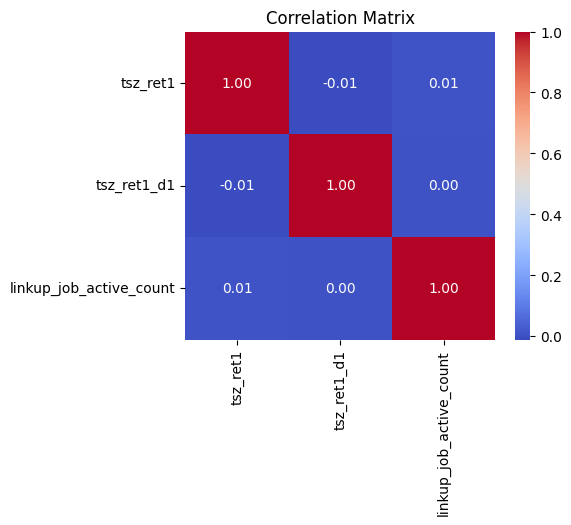

In [10]:
%matplotlib inline
plt.figure(figsize=(5, 4)) # adjust the figure size of the heatmap
correlation_matrix = df[features_ls].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

## **Training and validation**
- Training period: From 2006 to 2016 (11 years)
- Validation period: From 2017 to 2020 (4 years)

In [11]:
train_startdate = 20060101
train_enddate = 20161231

valid_startdate = 20170101
valid_enddate = 20201231

# split the df according to the periods of train/valid
train_mask = (df['dates'] >= train_startdate) & (df['dates'] <= train_enddate)
valid_mask = (df['dates'] >= valid_startdate) & (df['dates'] <= valid_enddate)

df_train = df[train_mask]
df_valid = df[valid_mask]
        
X_train,Y_train = df_train[features_ls].to_numpy(),df_train['target'].to_numpy()
X_valid,Y_valid = df_valid[features_ls].to_numpy(),df_valid['target'].to_numpy()

train_si,train_di = df_train['si'].values, df_train['di'].values
valid_si,valid_di = df_valid['si'].values, df_valid['di'].values

## **Model**

In [12]:
### ---- ---- ---- ---- Train your Model ---- ---- ---- ---- ###

from sklearn.ensemble import GradientBoostingRegressor

# train the model
regressor = GradientBoostingRegressor(n_estimators=400, learning_rate=0.1, max_depth=1, random_state=42)
regressor.fit(X_train, Y_train)

# predict
YPRED_train = regressor.predict(X_train)
YPRED_valid = regressor.predict(X_valid)

# alpha
alpha = np.full_like(data['ret1'], np.nan, dtype='float32', order='F')
alpha[train_si, train_di] = YPRED_train
alpha[valid_si, valid_di] = YPRED_valid

# accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
acc_train = accuracy_score(Y_train>=0, YPRED_train>=0)
acc_valid = accuracy_score(Y_valid>=0, YPRED_valid>=0)
print(f'Accuracy Train: {acc_train :>.3%}')
print(f'Accuracy Valid: {acc_valid :>.3%}')

Accuracy Train: 51.374%
Accuracy Valid: 51.371%


## **Simulation**

##### Post Processing (PP) function
- PP function applies the final risk-management constraints on the signal and makes our signal tradeable in real markets
- PP function reduces the turnover and increases the liquidity which reduces the slippage costs

In [13]:
# PP function - No need to modify the code below

def post_processing(data, preA, booksize):
    lookback = 252
    
    apply_locates = data['apply_locates']
    preA1 = np.copy(preA)
    preA1 *= data['valids']
  
    postA = op.at_nan2zero(preA1)
    postA = op.ts_mean_exp(op.at_nan2zero(postA), 5, 2/5)
    
    postA = op.cs_poslimit(postA, 0.1)
    postA = op.cs_indneut(postA, data['sector'])
    postA = op.cs_shrink_balance(postA)                                            

    long_scaler = op.ts_max(np.nansum(postA*(postA>0),axis=0),lookback)            
    short_scaler = op.ts_max(np.nansum(np.abs(postA)*(postA<0),axis=0),lookback)   
    scaler = np.maximum(long_scaler,short_scaler)                                  
    postA = postA/scaler * booksize                                                
    
    postA = op.op_vmcont(postA, data['valids'], data['close'], data['vol20'],
                         maxtrd=0.05*(booksize/1e9), maxpos=0.5*(booksize/1e9))
    postA = op.tc_hump(postA, data['close'], hump_factor=1.0)                      
    postA = op.cs_shrink_balance(postA)                                            

    long_scaler = op.ts_max(np.nansum(postA*(postA>0),axis=0),lookback)
    short_scaler = op.ts_max(np.nansum(np.abs(postA)*(postA<0),axis=0),lookback)
    scaler = np.maximum(long_scaler,short_scaler)
    postA = postA/scaler * booksize

    postA = op.cs_poslimit(postA, 0.1)
    postA = op.cs_shrink_balance(postA)                                            
    postA = apply_locates(postA, data, data['locate_utilization_rate'], data['max_rebate_rate'])
    return postA

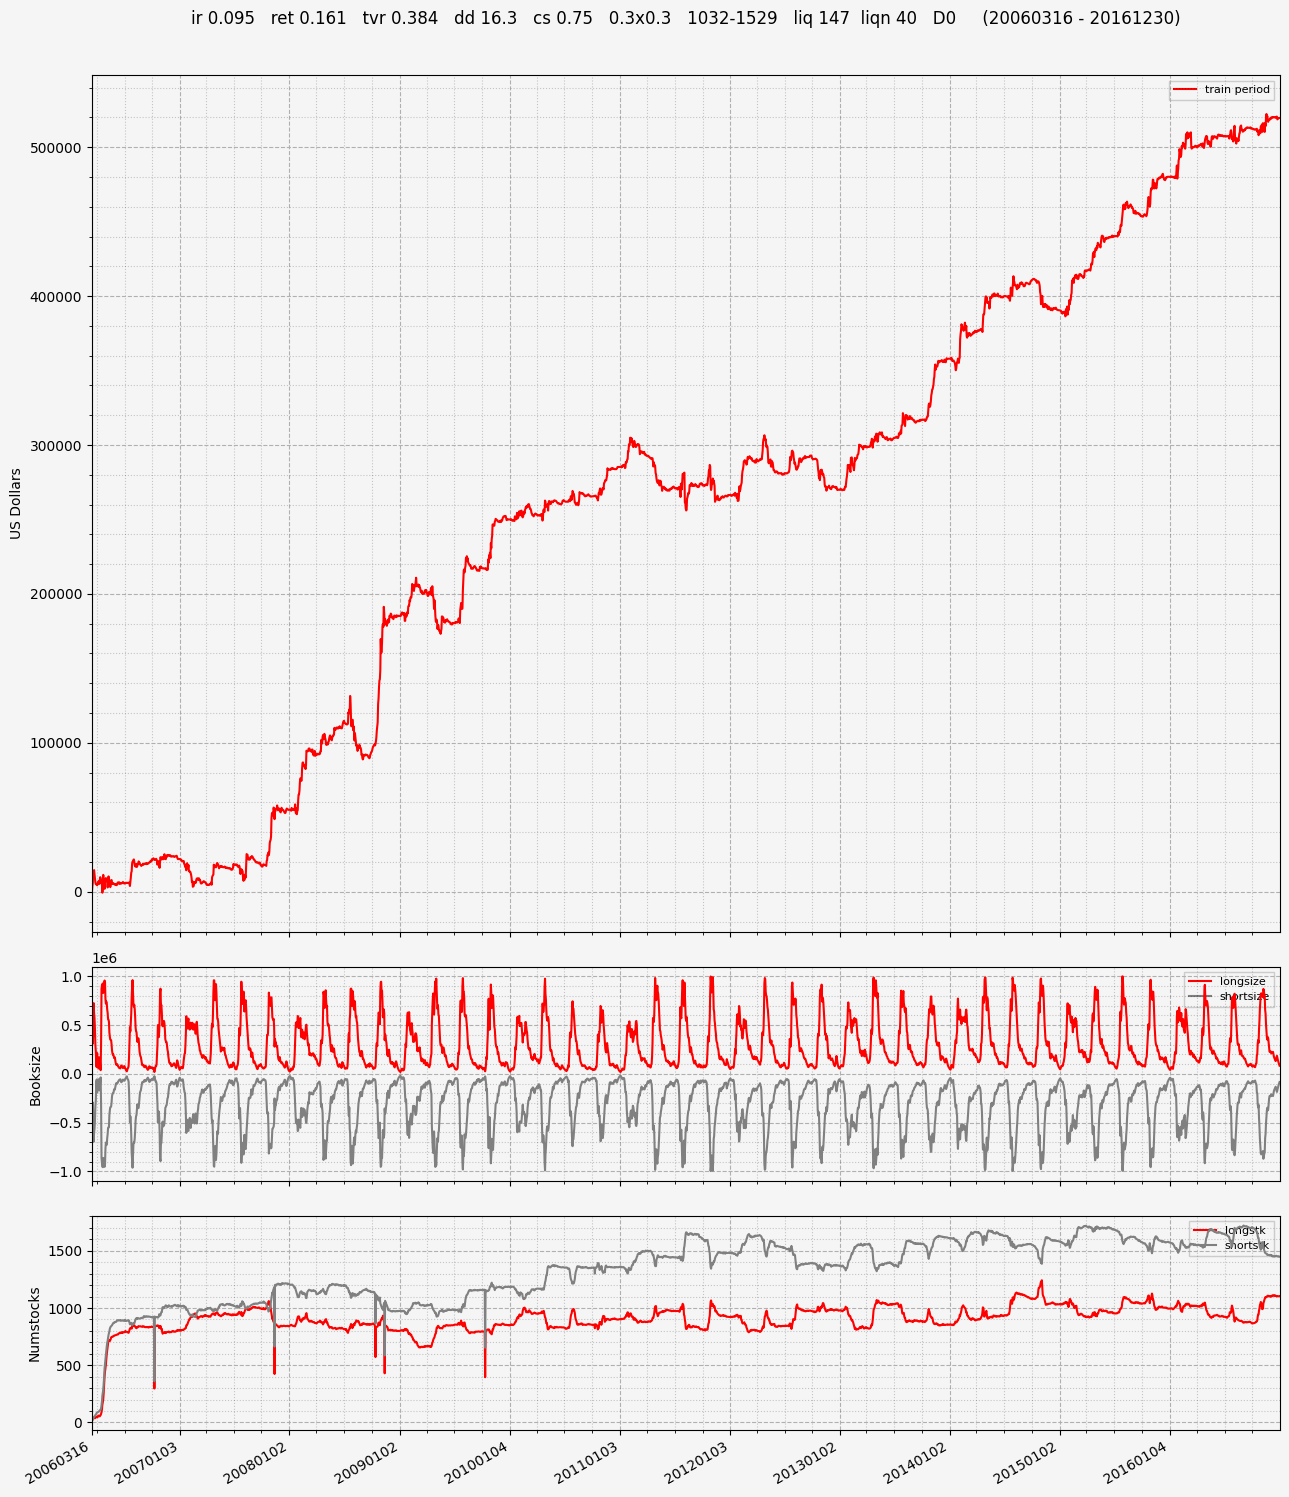

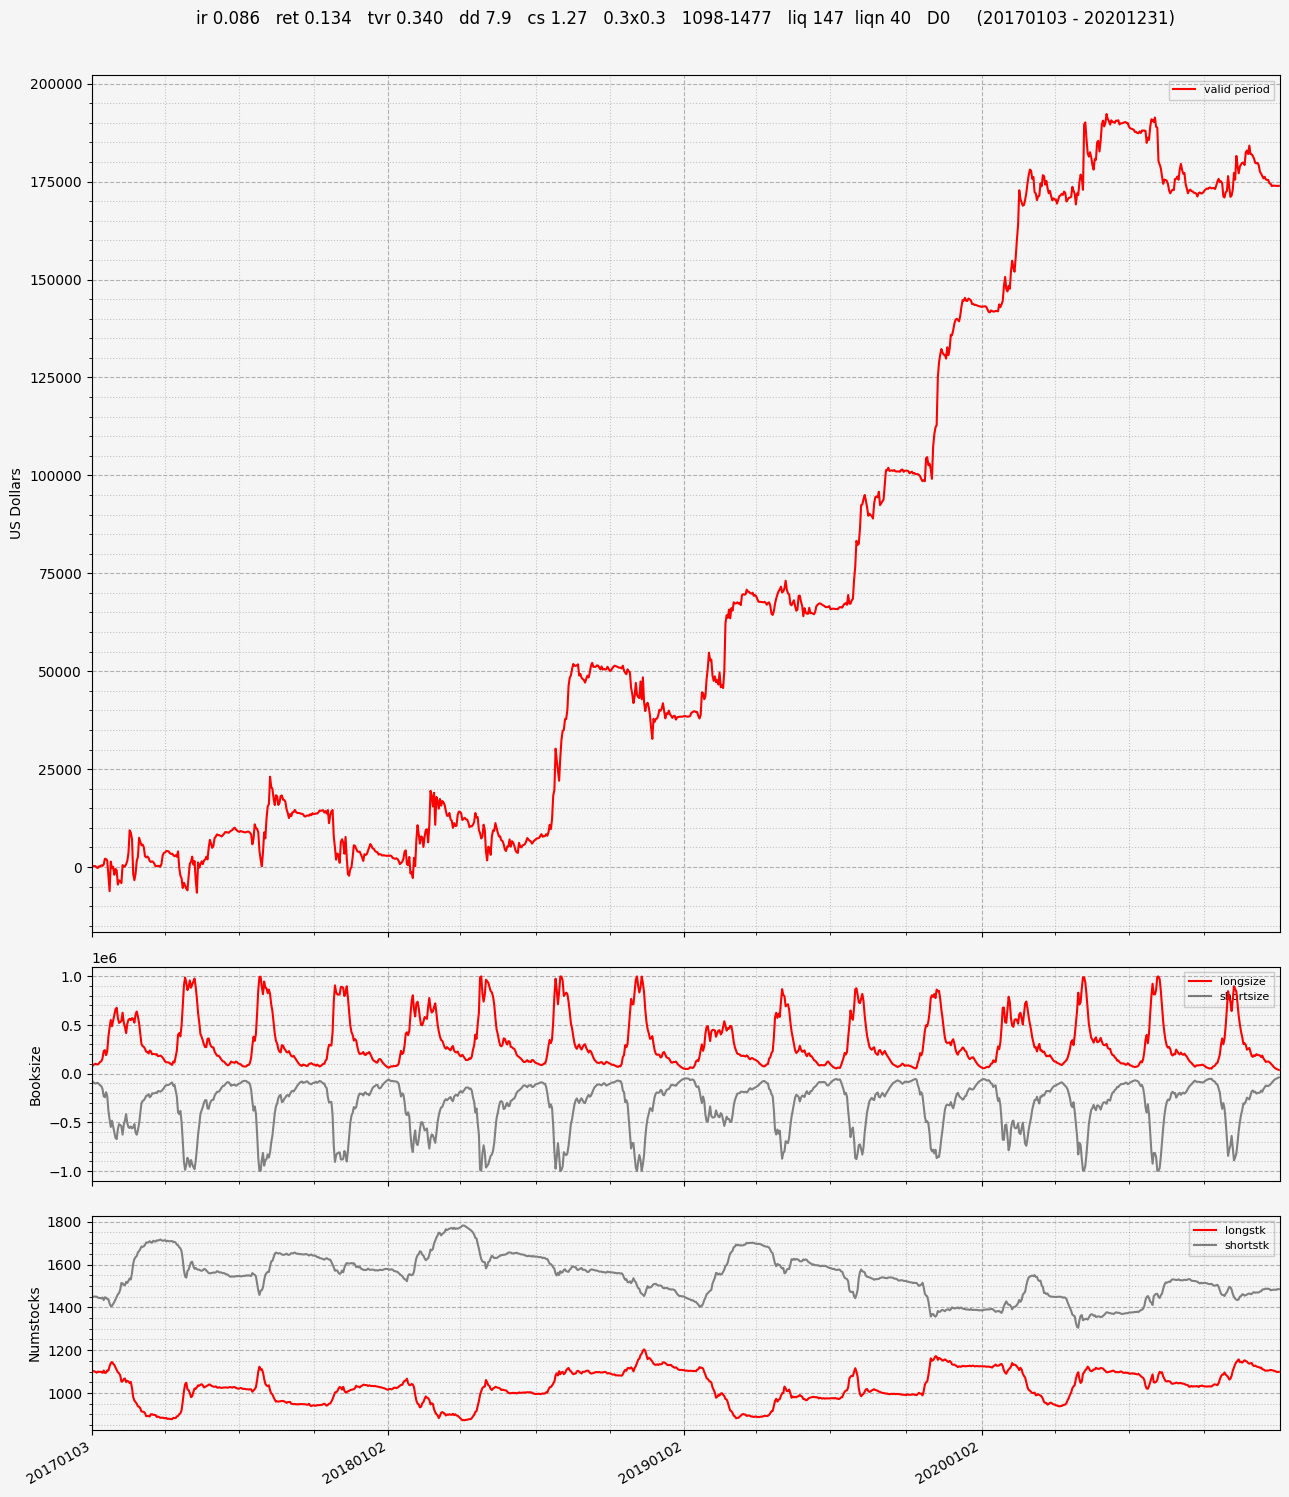

In [14]:
### ---- ---- ---- ---- No need to modify the code below ---- ---- ---- ---- ###
# simulation
postA = post_processing(data,alpha,data['booksize'])
postA[:, np.where(data['dates']>valid_enddate)[0][0]:]=np.nan # nan out values after valid_enddate

# simres = op.op_simulate(data,postA,0,liq_on_valid_days=True,calc_liqn=True,slippage=True, slippage_model='fraction_spread', fraction_spread=0.2)

# # simulation results
# simres_train = op.cut_simres(simres,startdate=train_startdate,enddate=train_enddate)
# simres_valid = op.cut_simres(simres,startdate=valid_startdate,enddate=valid_enddate)

# # pnl plots
# %matplotlib inline
# op.op_plot(op.cut_simres(simres,startdate=train_startdate,enddate=train_enddate),label='train period')
# op.op_plot(op.cut_simres(simres,startdate=valid_startdate,enddate=valid_enddate),label='valid period')

## **Backtest**

In [ ]:
from backtestv2 import Backtester
import matplotlib.pyplot as plt

In [ ]:
backtest_machine = Backtester(backtest_return, benchmark_returns='mean', compound=False)
res, year_res = backtest_machine.run_backtest(daily_weights_df)
res.to_csv('res.csv')
year_res.to_csv('year_res.csv')
plt.savefig('savefig.png')

In [2]:
import pandas as pd
daily_weights_df = pd.read_pickle('daily_weight_15_0.1_0.05.pkl')

In [4]:
daily_weights_df.index

DatetimeIndex(['2021-02-04', '2021-02-05', '2021-02-08', '2021-02-09',
               '2021-02-10', '2021-02-18', '2021-02-19', '2021-02-22',
               '2021-02-23', '2021-02-24',
               ...
               '2024-01-08', '2024-01-09', '2024-01-10', '2024-01-11',
               '2024-01-12', '2024-01-15', '2024-01-16', '2024-01-17',
               '2024-01-18', '2024-01-19'],
              dtype='datetime64[ns]', length=718, freq=None)